Load dataset.

In [0]:

import pandas as pd
import numpy as np

data = pd.read_csv('gdrive/My Drive/musk_csv.csv')


A look at the dataset.

In [5]:
data.head(3)

,ID,molecule_name,conformation_name,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,...,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,class
0,1,MUSK-211,211_1+1,46,-108,-60,-69,-117,49,38,-161,-8,5,-323,-220,-113,-299,-283,-307,-31,-106,-227,-42,-59,-22,-67,189,81,17,-27,-89,-67,105,-116,124,-106,5,-120,63,-165,...,81,-114,-187,45,-118,-75,-182,-234,-19,12,-13,-41,-119,-149,70,17,-20,-177,-101,-116,-14,-50,24,-81,-125,-114,-44,128,3,-244,-308,52,-7,39,126,156,-50,-112,96,1
1,2,MUSK-211,211_1+10,41,-188,-145,22,-117,-6,57,-171,-39,-100,-319,-111,-228,-281,-281,-300,54,-149,-98,-196,-27,-22,2,75,49,-34,45,-91,32,95,-116,85,-23,42,-58,61,-171,...,88,-21,-32,32,-128,-72,-124,-218,-94,53,-79,-20,-35,-26,4,50,17,-177,-102,-121,-66,-77,51,-41,-34,-32,-63,115,-5,-235,-59,-2,52,103,136,169,-61,-136,79,1
2,3,MUSK-211,211_1+11,46,-194,-145,28,-117,73,57,-168,-39,-22,-319,-111,-104,-283,-282,-303,52,-152,-97,-225,-28,-22,2,179,49,-33,46,-88,22,79,-116,19,-11,6,-38,71,-175,...,64,0,-23,-15,-129,-74,-125,-221,-93,53,-72,-19,-33,-26,3,49,17,-177,-102,-119,-66,-81,51,-41,-27,-41,-140,77,-163,-238,-134,-154,57,143,142,165,-67,-145,39,1


Checking if null values are present.

In [6]:
data.isnull().sum()

ID                   0
molecule_name        0
conformation_name    0
f1                   0
f2                   0
                    ..
f163                 0
f164                 0
f165                 0
f166                 0
class                0
Length: 170, dtype: int64

Dividing the dataset into 1's and 0's along with their corresponding labels.

In [0]:
data_1 = data[data['class']==1].iloc[:,3:-1]
data_0 = data[data['class']==0].iloc[:,3:-1]
y_1 = data[data['class']==1].iloc[:,-1]
y_0 = data[data['class']==0].iloc[:,-1]

In [0]:
data_1 = data_1.values
data_0 = data_0.values

How I am planning to approach this problem is, since these values follow a pattern, I will be plotting every row and on these images, I will apply CNN. 

Will be plotting the rows with label 1 first

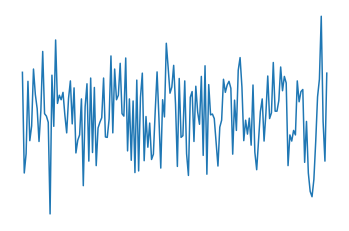

In [10]:
%matplotlib inline
import pylab as plt

def im_1(l1):
    i=0
    fig=plt.figure(frameon=False)
    while(i!=len(l1)):
        fig.clf()
        p1=l1[i]
        plt.plot(p1)
        plt.axis('off')
        plt.savefig('classification project//class1//sample_1_'+str(i)+".png")
        i+=1
im_1(data_1)

Will be plotting the rows with label 0's next.

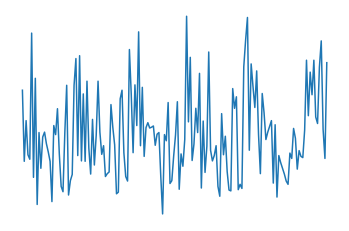

In [11]:
%matplotlib inline
import pylab as plt

def im_0(l1):
    i=0
    fig=plt.figure(frameon=False)
    while(i!=len(l1)):
        fig.clf()
        p1=l1[i]
        plt.plot(p1)
        plt.axis('off')
        plt.savefig('classification project//class0//sample_0_'+str(i)+".png")
        i+=1
im_0(data_0)

Corresponding paths. path3 will hold the grey scaled images AFTER they are preprocessed.

In [0]:
path1='classification project//class0'
path2='classification project//class1'
path3='classification project//preprocessed'

Creating lists of image names.

In [ ]:
import os
from PIL import Image

listing0=os.listdir(path1)
listing1=os.listdir(path2)


Resizing the image and storing it in path3 which is supposed to store preprocessed images.

In [0]:
for file in listing0:
    im=Image.open(path1 + '//' + file)
    img=im.resize((256,256))
    gray=img.convert('L')
    gray.save(path3 + '//' + file, "JPEG")

In [0]:
for file in listing1:
    im=Image.open(path2 + '//' + file)
    img=im.resize((256,256))
    gray=img.convert('L')
    gray.save(path3 + '//' + file, "JPEG")

In [0]:
imlist=os.listdir(path3)

Checking if the totals(samples) match up. Yes, they do.

In [4]:
len(imlist), len(listing0), len(listing1)

(6598, 5581, 1017)

Since initially we don't know the index locations of the classes(0 & 1), we will be distinguishing the images corresponding to class 1 only.

To do this, we will

first generate a list of strings which match with the image names we are trying to find out the index locations of.
We then run a loop and if a match is found between the real directory containing images and the list previously created, we will be collecting index locations of the image names corresponding to class 1.


In [0]:
list1=[]
for i in range(0,1017):
    list1.append('sample_1_'+str(i)+'.png')

#Step 2        
list2=[]
for i in range(0,len(imlist)):
      if imlist[i] in list1:
        list2.append(i)

Importing necessary APIs


In [6]:
# For controlling Python warnings - https://docs.python.org/3.6/library/warnings.html
import warnings
warnings.filterwarnings("ignore")

# For iterators - https://docs.python.org/3.1/library/itertools.html
import itertools

# For loading and handling data
import numpy as np
import pandas as pd

# For Normalization
from sklearn.preprocessing import MinMaxScaler

# For constructing DNN
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from keras.layers import Input,Dropout,Dense 
from keras.models import Model
from keras import regularizers
from keras.utils.data_utils import get_file

# For visualization
import matplotlib.pyplot as plt

# For evaluating the accuracy
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
%matplotlib inline
import os

Using TensorFlow backend.


In [0]:
from numpy import *

num_samples=size(imlist)

Converting these images into array of pixels.

In [0]:
immatrix=array([array(Image.open('classification project/preprocessed' + '/' + im2)).flatten() for im2 in imlist], 'f')

Creating an array of size equal to the row size of the data with initial values 1. We will then use the index locations which we found out earlier to change these label values to either 0 (if index of the new loop does not match with label) or 1 (if index of the new loop matches with the label)



In [0]:
labels=np.ones((num_samples,), dtype=int)

In [0]:
for i in range(0,len(labels)):
    if i in list2:
        labels[i]=1
    else:
        labels[i]=0

Creating a dataframe.

In [0]:
df1=pd.DataFrame(immatrix)

In [0]:
defi=labels.tolist()
df1['class']=labels

# Class Imbalance problem

Non musk samples dominate the dataset.  

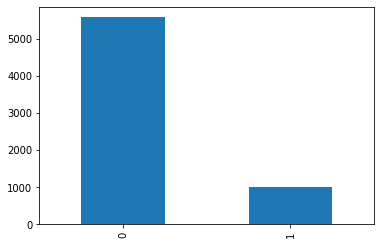

In [15]:
pd.Series(df1.iloc[:,-1]).value_counts().plot.bar()

Only 15% of the dataset constitute samples belonging to Musk labels.

In [16]:
df1['class'].value_counts()/len(df1)

0    0.845862
1    0.154138
Name: class, dtype: float64

In [0]:

X=np.array(df1.loc[:,df1.columns!='class'])
y=np.array(df1.loc[:,df1.columns=='class']).reshape(-1,1)

Before we deal with class imbalance, lets scale data.

In [0]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X=scaler.fit_transform(X)


Splitting data into train and test, for validation purposes.

In [0]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=2, shuffle=True,stratify=y)


Balancing the dataset using SMOTE.

In [0]:
from imblearn.over_sampling import SMOTE

sm=SMOTE(random_state=33)


In [0]:
X_train_new, y_train_new=sm.fit_sample(X_train,y_train.ravel())


Balanced data.

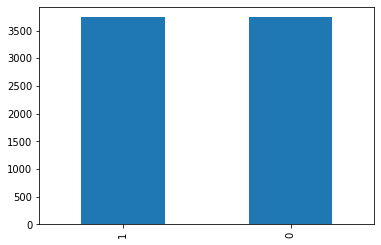

In [22]:
pd.Series(y_train_new).value_counts().plot.bar()

In [0]:
X_train_cnn=X_train_new
y_train_cnn=y_train_new
X_test_cnn=X_test
y_test_cnn=y_test.ravel()


In [24]:
print(X_train_cnn.shape)
print(y_train_cnn.shape)
print(X_test_cnn.shape)
print(y_test_cnn.shape)


(7478, 65536)
(7478,)
(2178, 65536)
(2178,)


Converting these samples into 3 Dimenstions. (x,y,channel)

In [0]:
img_row,img_col=256,256
X_train_cnn=X_train_cnn.reshape(X_train_cnn.shape[0],img_row,img_col,1).astype('float32')
X_test_cnn=X_test_cnn.reshape(X_test_cnn.shape[0],img_row,img_col,1).astype('float32')

One hot encoding the y labels.

In [0]:
from keras.utils import np_utils
y_train_cnn=np_utils.to_categorical(y_train_cnn,2)
y_test_cnn=np_utils.to_categorical(y_test_cnn,2)

In [0]:
from keras.models import Sequential
from keras.layers import MaxPooling2D, Conv2D, Dropout, Dense, Flatten, Activation, Input
from keras.optimizers import Adam


The CNN architecture, a very basic one.

In [0]:
model=Sequential()

model = Sequential()
model.add(Conv2D(32, (3,3),activation='relu',input_shape=(256,256,1)))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.25)) # For regularization
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

Since this is a multi class classification, we will be using softmax along with categorical crossentropy.

In [29]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
#default lr of 0.001 is good enough for this problem.
model.fit(X_train_cnn,y_train_cnn,batch_size=128,epochs=10,verbose=1, validation_data=(X_test_cnn,y_test_cnn))


Train on 7478 samples, validate on 2178 samples
Epoch 1/10
7478/7478 [==============================] - 27s 4ms/step - loss: 7.1297 - acc: 0.5350 - val_loss: 1.0194 - val_acc: 0.7672
Epoch 2/10
7478/7478 [==============================] - 10s 1ms/step - loss: 0.2026 - acc: 0.9271 - val_loss: 0.1144 - val_acc: 0.9605
Epoch 3/10
7478/7478 [==============================] - 10s 1ms/step - loss: 0.0382 - acc: 0.9876 - val_loss: 0.0812 - val_acc: 0.9720
Epoch 4/10
7478/7478 [==============================] - 10s 1ms/step - loss: 0.0186 - acc: 0.9932 - val_loss: 0.0676 - val_acc: 0.9775
Epoch 5/10
7478/7478 [==============================] - 10s 1ms/step - loss: 0.0106 - acc: 0.9971 - val_loss: 0.0833 - val_acc: 0.9780
Epoch 6/10
7478/7478 [==============================] - 10s 1ms/step - loss: 0.0097 - acc: 0.9972 - val_loss: 0.0828 - val_acc: 0.9789
Epoch 7/10
7478/7478 [==============================] - 10s 1ms/step - loss: 0.0100 - acc: 0.9972 - val_loss: 0.0743 - val_acc: 0.9821
Epoch 8

To assess the performance, we will need the predictions.

In [0]:
preds=model.predict_classes(X_test_cnn[:])
y_test_values=y_test_cnn[:,1]

Sometimes, accuracy can be misleading. So we will judge our model based on other metrics. F1, Precision, recall and MCC.
Note: MCC is very powerful as it takes into account True Positives, True Negatives, False Positives and False Negatives.

In [0]:
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef

Good enough.

In [34]:
print(f1_score(y_test_values,preds))
print(precision_score(y_test_values,preds))
print(recall_score(y_test_values,preds))
print(matthews_corrcoef(y_test_values,preds))

0.931888544891641
0.9709677419354839
0.8958333333333334
0.9210796859918882


Accuracy and loss plots for both training and test data.

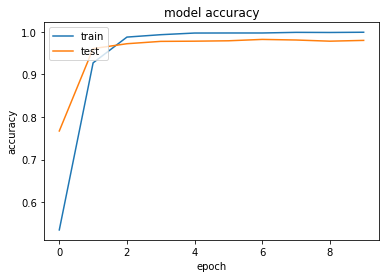

In [30]:
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

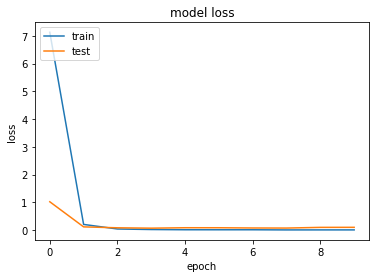

In [31]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()